## Temperature Stabilized Measurements - 30°C, bubbles/no bubbles, H2O

### Loading the Libraries

In [1]:
import os
import earthpy as et
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sp
import statsmodels.formula.api as smf

import matplotlib.colors as col


import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
pd.options.plotting.backend = "matplotlib" #Abändern des Plot Backends
#pd.options.plotting.backend = "plotly"
pd.options.mode.use_inf_as_na = True

In [28]:
import sys

if sys.platform.startswith('linux'):
    # Linux specific procedures
    pass
elif sys.platform.startswith('darwin'):
    # MacOs specific procedures
    df_b = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData30_H2O_2021-06-22bubbled.csv", sep=",")
    df_ub = pd.read_csv(r"/Volumes/Data/usePAT/technology/experiments/sonicMeasure/data/RunsTControlled/sonicMeasureRunData30_H2O_2021-06-22unbubbled.csv", sep=",")
    

elif sys.platform.startswith('win32'):
    # Windows specific procedures
    df_b = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\data\RunsTControlled\sonicMeasureRunData30_H2O_2021-06-22bubbled.csv", sep=",")
    df_ub = pd.read_csv(r"C:\Users\Stefan\Documents\usePAT\technology\experiments\sonicMeasure\data\RunsTControlled\sonicMeasureRunData30_H2O_2021-06-22unbubbled.csv", sep=",")

In [29]:
os.getcwd()

'C:\\Users\\Stefan\\Documents\\usePAT\\technology\\experiments\\sonicMeasure\\ST'

### About the Data

Features:
- timestamp: Datetimeobject
- Urms: Outputvoltage in FSV
- Irms: Outputcurrent in FSV
- phase: Phase between Urms nad Irms in FSV
- frequency: in kHz
- on-status: 0...US is off, 1...US is on
- temperature: temperature of the reactorvessel in °C
- bubbles yes/no
- dTime: elapsed time in sec from the last measurement; value of first instance is mean of column

In [30]:
df_b['timestamp'] = pd.to_datetime(df_b['timestamp'])
df_b_status = df_b['on-status']
df_b_status = df_b_status.map({'off': 0, 'on':1})
df_b['on-status'] = df_b_status
df_b.insert(7,'bubbles', 1)
df_b = df_b.loc[df_b.temperature >29.8] #get rid of data in range of unstable temp at beginning
df_b = df_b.reset_index()
del df_b['index']
df_b['delta_t'] =  df_b['timestamp'] - df_b['timestamp'].shift()
df_b['dTime'] = df_b['delta_t'].dt.total_seconds() #deltaT as column
del df_b['delta_t']
df_b.fillna(df_b.mean(), inplace=True) #fill all NaN with mean of column
df_b

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,bubbles,dTime
0,2021-06-22 06:39:29.944674,2829.0,2890.0,7429.0,2077,0,29.94,1,7.111079
1,2021-06-22 06:39:37.079397,2829.0,2890.0,7425.0,2077,0,30.11,1,7.134723
2,2021-06-22 06:39:44.118167,2829.0,2890.0,7429.0,2077,0,30.27,1,7.038770
3,2021-06-22 06:39:51.156951,2829.0,2890.0,7429.0,2077,0,30.39,1,7.038784
4,2021-06-22 06:39:58.291537,2829.0,2891.0,7424.0,2077,0,30.56,1,7.134586
...,...,...,...,...,...,...,...,...,...
2647,2021-06-22 11:53:12.522976,24678.0,4758.0,9867.0,2207,1,29.96,1,7.150731
2648,2021-06-22 11:53:19.657933,24685.0,4765.0,9869.0,2207,1,29.95,1,7.134957
2649,2021-06-22 11:53:27.128717,24688.0,4766.0,9876.0,2207,1,29.97,1,7.470784
2650,2021-06-22 11:53:34.279099,24690.0,4765.0,9875.0,2207,1,29.98,1,7.150382


In [31]:
df_ub['timestamp'] = pd.to_datetime(df_ub['timestamp'])
df_ub_status = df_ub['on-status']
df_ub_status = df_ub_status.map({'off': 0, 'on':1})
df_ub['on-status'] = df_ub_status
df_ub.insert(7,'bubbles', 0)
df_ub['delta_t'] =  df_ub['timestamp'] - df_ub['timestamp'].shift()
df_ub['dTime'] = df_ub['delta_t'].dt.total_seconds()#deltaT as column
del df_ub['delta_t']
df_ub.fillna(df_ub.mean(), inplace=True) #fill all NaN with mean of column
df_ub

,timestamp,Urms,Irms,phase,frequency,on-status,temperature,bubbles,dTime
0,2021-06-22 12:53:14.443071,2830.0,2891.0,7432.0,2007,0,30.09,0,7.082491
1,2021-06-22 12:53:21.785890,2830.0,2891.0,7429.0,2007,0,30.08,0,7.342819
2,2021-06-22 12:53:28.824648,2830.0,2891.0,7432.0,2007,0,30.08,0,7.038758
3,2021-06-22 12:53:35.846313,2830.0,2891.0,7429.0,2007,0,30.10,0,7.021665
4,2021-06-22 12:53:42.997948,2830.0,2891.0,7432.0,2007,0,30.09,0,7.151635
...,...,...,...,...,...,...,...,...,...
594,2021-06-22 14:03:21.633543,24733.0,4495.0,9554.0,2207,1,29.92,0,7.135008
595,2021-06-22 14:03:28.672196,24739.0,4496.0,9559.0,2207,1,29.92,0,7.038653
596,2021-06-22 14:03:35.694993,24742.0,4495.0,9563.0,2207,1,29.90,0,7.022797
597,2021-06-22 14:03:42.733698,24744.0,4496.0,9563.0,2207,1,29.92,0,7.038705


### Inspecting the data

In [32]:
df_b.describe()

,Urms,Irms,phase,frequency,on-status,temperature,bubbles,dTime
count,2652.000000,2652.000000,2652.00000,2652.000000,2652.000000,2652.000000,2652.0,2652.000000
mean,5128.393288,4527.672700,7931.72549,2108.730769,0.111237,30.060298,1.0,7.111079
std,6513.729967,5221.568981,1539.59457,36.404802,0.314484,0.238604,0.0,0.161754
min,2826.000000,2884.000000,7413.00000,2007.000000,0.000000,29.880000,1.0,7.018365
25%,2828.000000,2888.000000,7425.00000,2102.000000,0.000000,29.970000,1.0,7.038503
50%,2828.000000,2889.000000,7428.00000,2107.000000,0.000000,30.005000,1.0,7.039114
75%,2829.000000,2890.000000,7432.00000,2112.000000,0.000000,30.052500,1.0,7.149817
max,25051.000000,26418.000000,14955.00000,2207.000000,1.000000,31.910000,1.0,11.837929


In [33]:
df_ub.describe()

,Urms,Irms,phase,frequency,on-status,temperature,bubbles,dTime
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.0,599.000000
mean,13432.560935,8476.178631,9231.103506,2106.949917,0.499165,30.031853,0.0,7.082491
std,10676.133482,7671.325555,2165.709646,38.409397,0.500417,0.094967,0.0,0.322527
min,2821.000000,2872.000000,7410.000000,2007.000000,0.000000,29.880000,0.0,7.016494
25%,2825.000000,2884.000000,7423.000000,2102.000000,0.000000,29.950000,0.0,7.023178
50%,2830.000000,2891.000000,7435.000000,2107.000000,0.000000,30.030000,0.0,7.038740
75%,24773.000000,11239.000000,10235.500000,2112.000000,1.000000,30.100000,0.0,7.135069
max,25099.000000,29394.000000,15025.000000,2207.000000,1.000000,30.250000,0.0,14.845244


In [34]:
b_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']
ub_features = ['Urms', 'Irms', 'phase', 'frequency', 'on-status','temperature']

features_PCA = ['Urms', 'Irms', 'phase', 'frequency', 'bubbles']


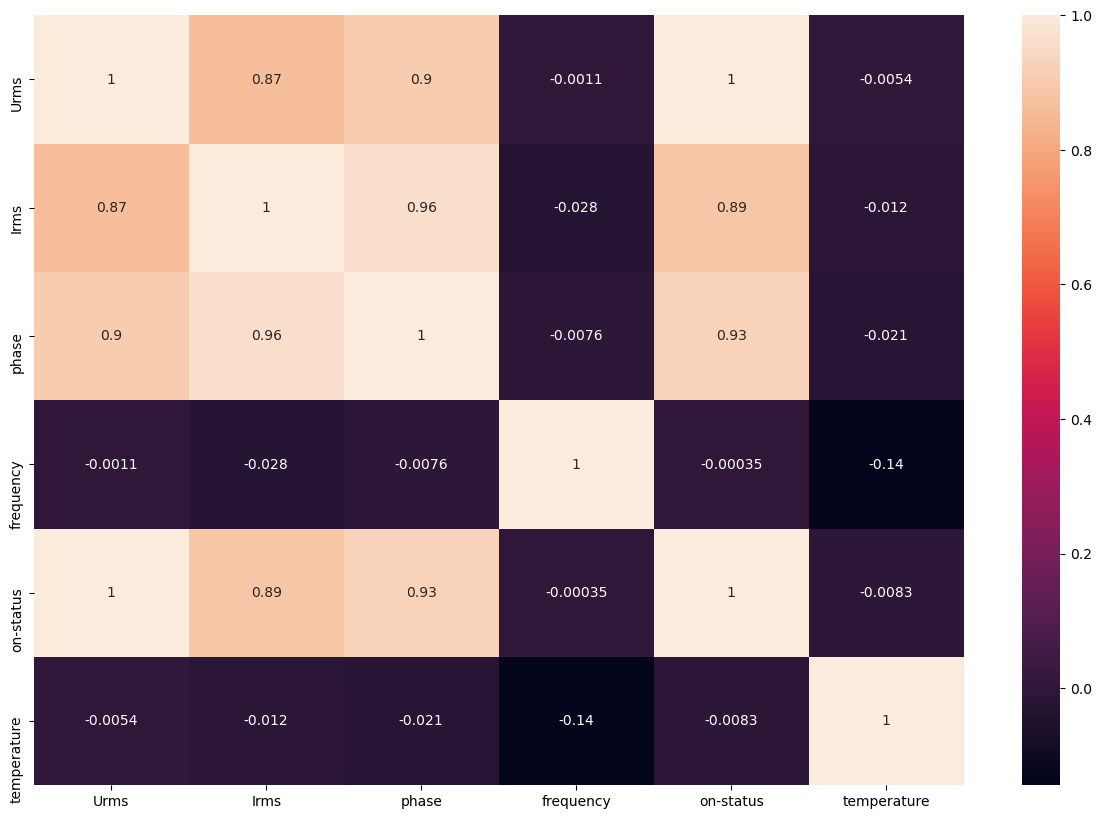

In [68]:
corr = df_b[b_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

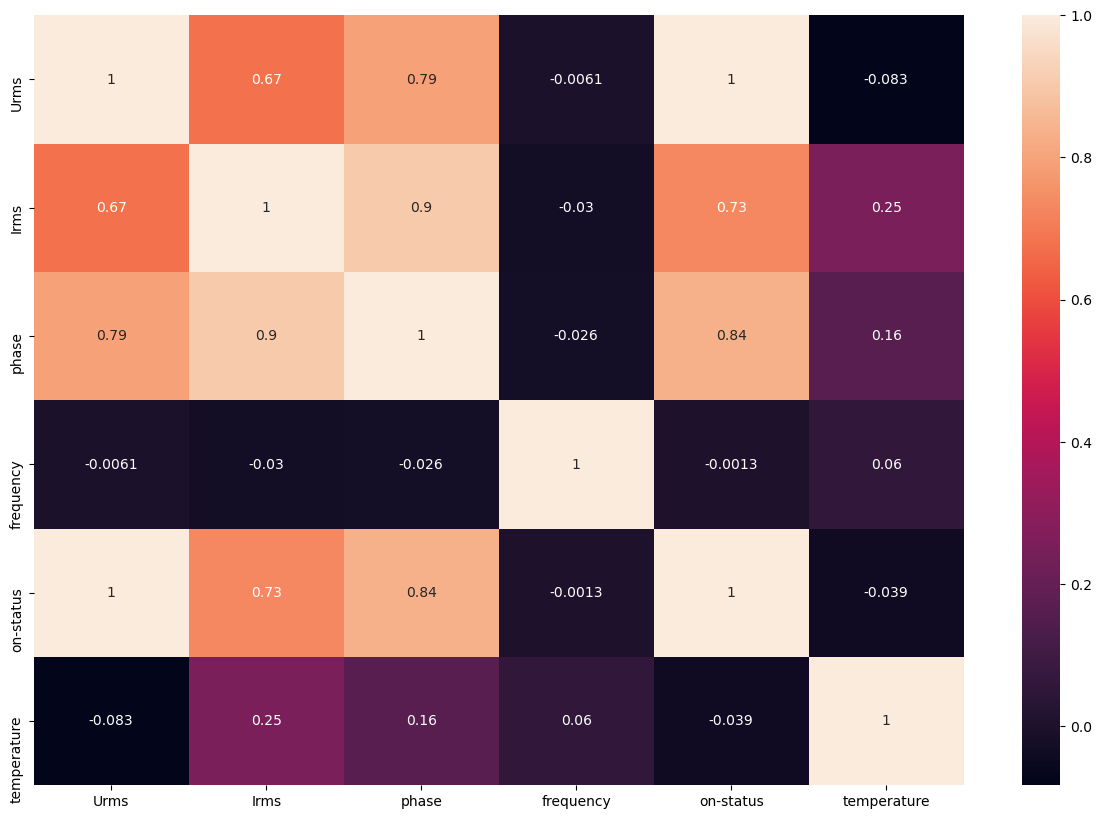

In [69]:
corr = df_ub[ub_features].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

As we want to include the concentration feature, we need to combine the datasets

### PCA

In order to include concentrations of particles we cobine the datasets to one single df.

In [70]:
df = df_b.append(df_ub)
df = df.rename(columns={'on-status' : 'on_status'})
df = df[df.on_status != 0]
df.reset_index(drop=True, inplace=True)
df

,timestamp,Urms,Irms,phase,frequency,on_status,temperature,bubbles,dTime
0,2021-06-22 06:43:56.601777,25022.0,10618.0,10001.0,2077,1,31.74,1,7.151006
1,2021-06-22 06:44:03.624554,25026.0,10625.0,10006.0,2077,1,31.74,1,7.022777
2,2021-06-22 06:44:10.663117,25029.0,10634.0,10007.0,2077,1,31.70,1,7.038563
3,2021-06-22 06:44:17.702016,25031.0,10641.0,10010.0,2077,1,31.68,1,7.038899
4,2021-06-22 06:44:24.724798,25033.0,10648.0,10008.0,2077,1,31.63,1,7.022782
...,...,...,...,...,...,...,...,...,...
589,2021-06-22 14:03:21.633543,24733.0,4495.0,9554.0,2207,1,29.92,0,7.135008
590,2021-06-22 14:03:28.672196,24739.0,4496.0,9559.0,2207,1,29.92,0,7.038653
591,2021-06-22 14:03:35.694993,24742.0,4495.0,9563.0,2207,1,29.90,0,7.022797
592,2021-06-22 14:03:42.733698,24744.0,4496.0,9563.0,2207,1,29.92,0,7.038705


In [71]:
from sklearn.preprocessing import StandardScaler
#Declaration of the features 

x_1 = df[features_PCA].copy()

# Define the scaler 
scaler_PCA = StandardScaler().fit(x_1)
# Scale the dataset
x_1 = pd.DataFrame(scaler_PCA.transform(x_1), columns=x_1.columns) #we need a df instead of an array for further processing
x_1

,Urms,Irms,phase,frequency,bubbles
0,0.976326,-0.694752,-0.847374,-0.822808,1.006757
1,0.979505,-0.693822,-0.844547,-0.822808,1.006757
2,0.981889,-0.692625,-0.843982,-0.822808,1.006757
3,0.983479,-0.691694,-0.842287,-0.822808,1.006757
4,0.985068,-0.690764,-0.843417,-0.822808,1.006757
...,...,...,...,...,...
589,0.746655,-1.508815,-1.100040,2.651070,-0.993289
590,0.751423,-1.508682,-1.097213,2.651070,-0.993289
591,0.753807,-1.508815,-1.094952,2.651070,-0.993289
592,0.755396,-1.508682,-1.094952,2.651070,-0.993289


In [72]:
#Declaration of the concentration as target 
y_1 = df['bubbles'].copy()

y_1

0      1
1      1
2      1
3      1
4      1
      ..
589    0
590    0
591    0
592    0
593    0
Name: bubbles, Length: 594, dtype: int64

In [73]:
from sklearn.decomposition import PCA
n_components = 3
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(x_1)
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['principal component 1', 'principal component 2', 'principal component 3', ])
#principalDf
pca.get_covariance()

array([[ 1.03058201, -0.84164815, -0.85757778, -0.05979142, -0.22729469],
       [-0.84164815,  0.98077345,  0.83799125, -0.11038006,  0.23427013],
       [-0.85757778,  0.83799125,  0.99312048, -0.04770257,  0.25888452],
       [-0.05979142, -0.11038006, -0.04770257,  1.00222928,  0.02379225],
       [-0.22729469,  0.23427013,  0.25888452,  0.02379225,  1.00172647]])

In [74]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.55732673, 0.20518286, 0.17905446])

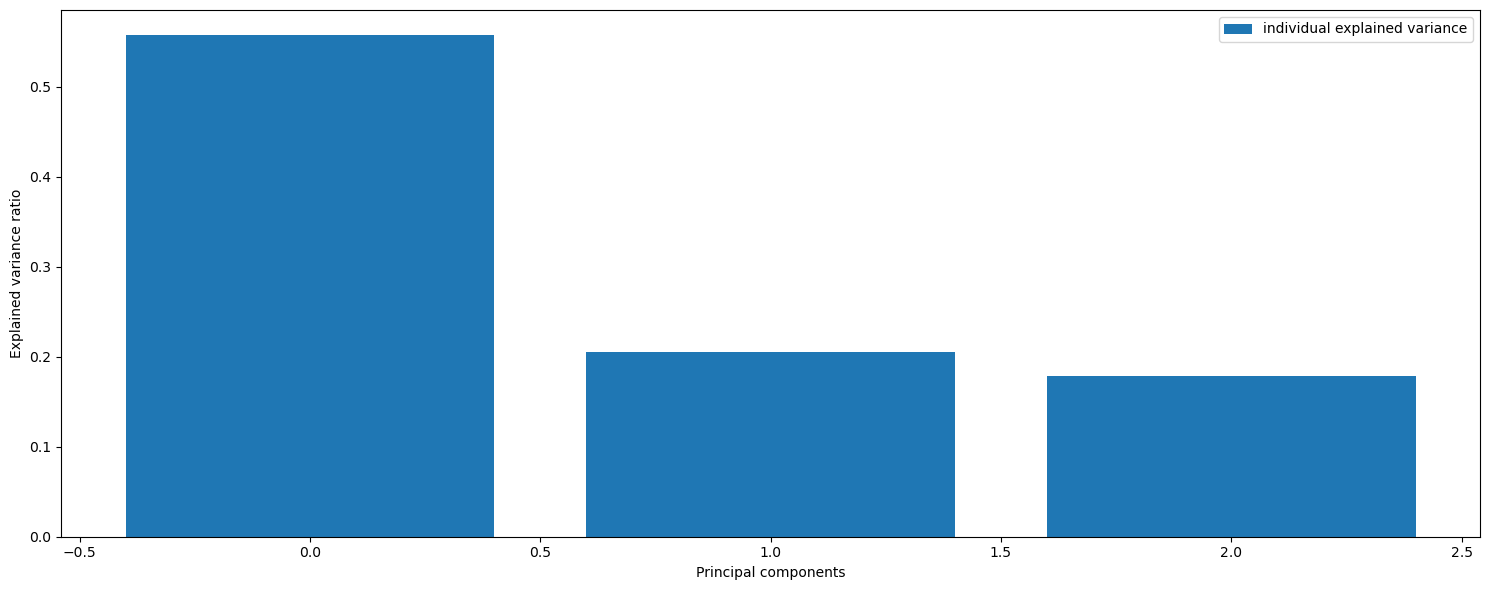

In [78]:
    plt.figure(figsize=(15, 6))

    plt.bar(range(n_components), explained_variance, alpha=1, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [79]:
PCAcomp = pd.DataFrame(principalComponents)
PC_dict = {}
for idx,v in enumerate(PCAcomp):
    PC_dict[idx] = 'PC '+str(idx+1)
PCAcomp.rename(columns=PC_dict, inplace=True)
PCAcomp['bubbles'] = y_1.values
PCAcomp

,PC 1,PC 2,PC 3,bubbles
0,-1.167649,-0.492733,1.494012,1
1,-1.167347,-0.493166,1.494222,1
2,-1.167718,-0.493496,1.494483,1
3,-1.167149,-0.493772,1.494511,1
4,-1.168171,-0.493958,1.494822,1
...,...,...,...,...
589,-2.178403,2.407401,-1.215287,0
590,-2.179446,2.406931,-1.214701,0
591,-2.179601,2.406690,-1.214472,0
592,-2.180430,2.406554,-1.214192,0


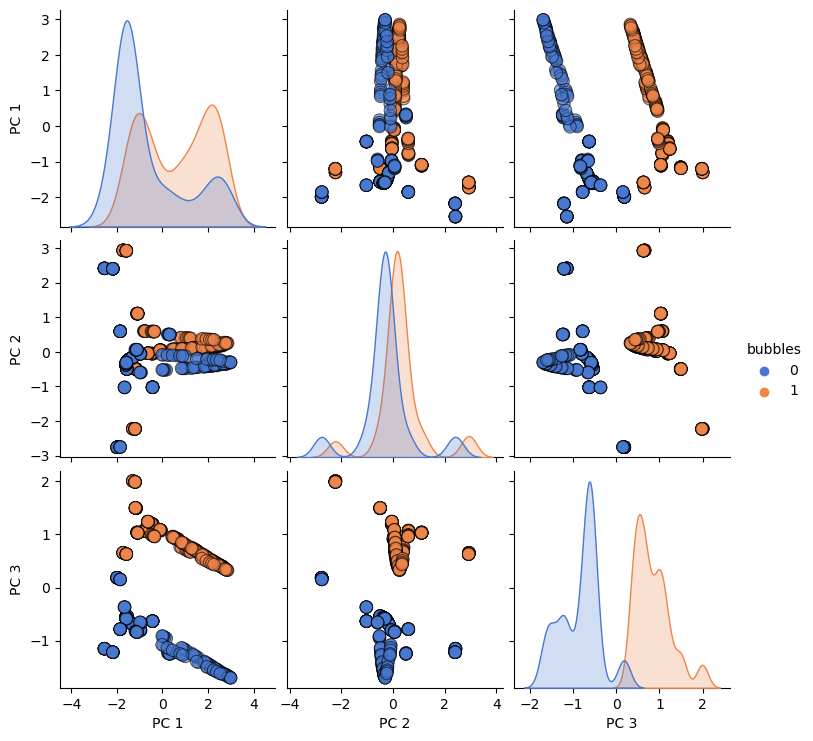

In [80]:
fig0 = sns.pairplot(PCAcomp, hue='bubbles', palette = 'muted', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}) 
plt.show(fig0)

### Effect of features on the principle components

The components_ attribute provides principal axes in the feature space, representing the directions of maximum variance in the data. 

This means, we can see influence on each of the components by features. Reference: Ostwald Prasad


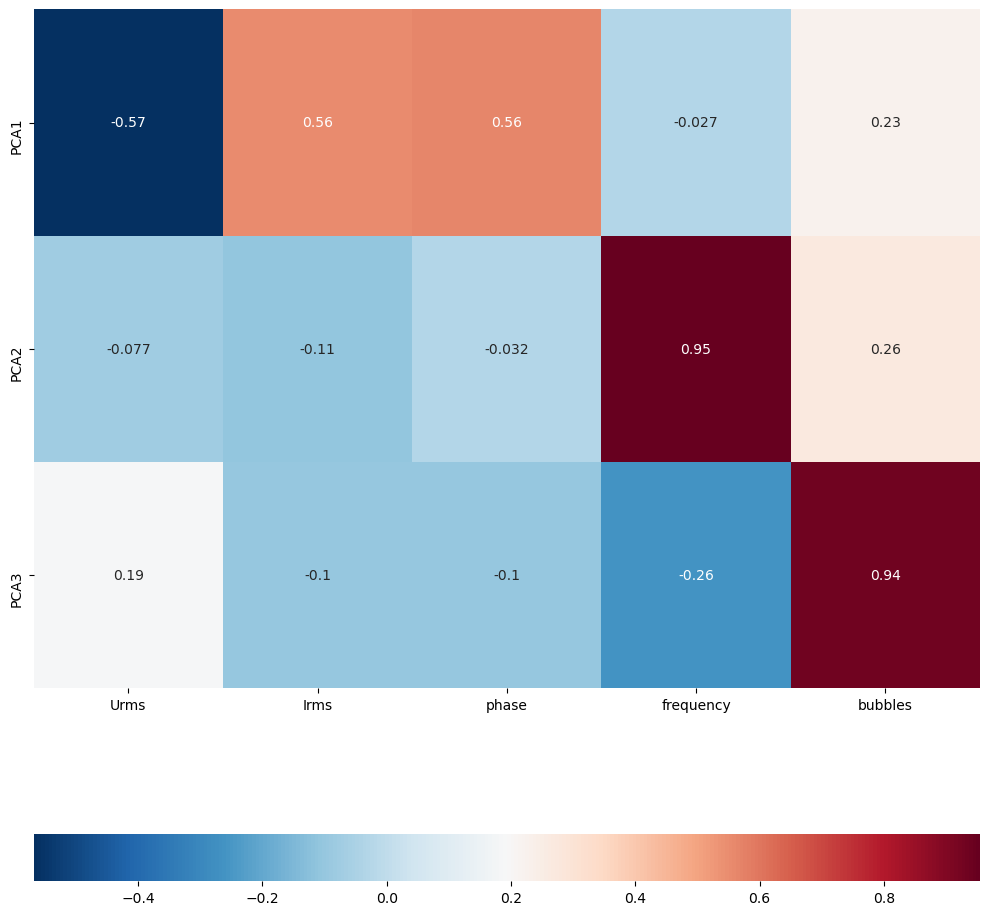

In [81]:
plt.figure(figsize=(10, 10))
sns.heatmap(pca.components_,
                 cmap='RdBu_r',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(x_1.columns),
                 annot= True,
                 cbar_kws={"orientation": "horizontal"})
plt.tight_layout()
plt.show()

This heatmap shows the main contributing features to the PCs. The distinct contributers to the first PC are XXX. . 
The second PC is interesting in the fact that it represents the interdependencies, by the laws of physics and the nature of biological fermentation, between residual sugar, density and alcohol. The third PC shows the interdependencies of acidity and the pH value of the wine.

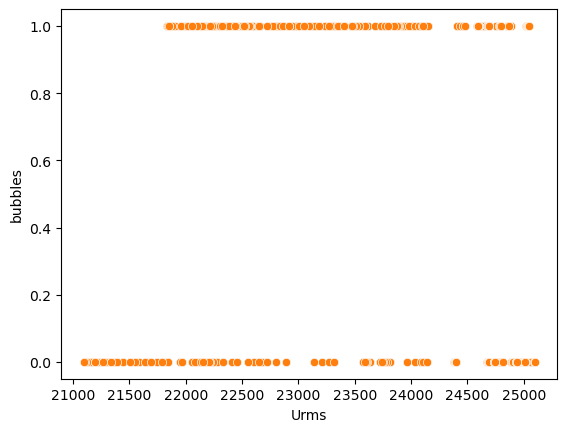

In [83]:
sns.scatterplot(data=df, x="Urms", y="bubbles")
plt.show()

### Correlation combined DF

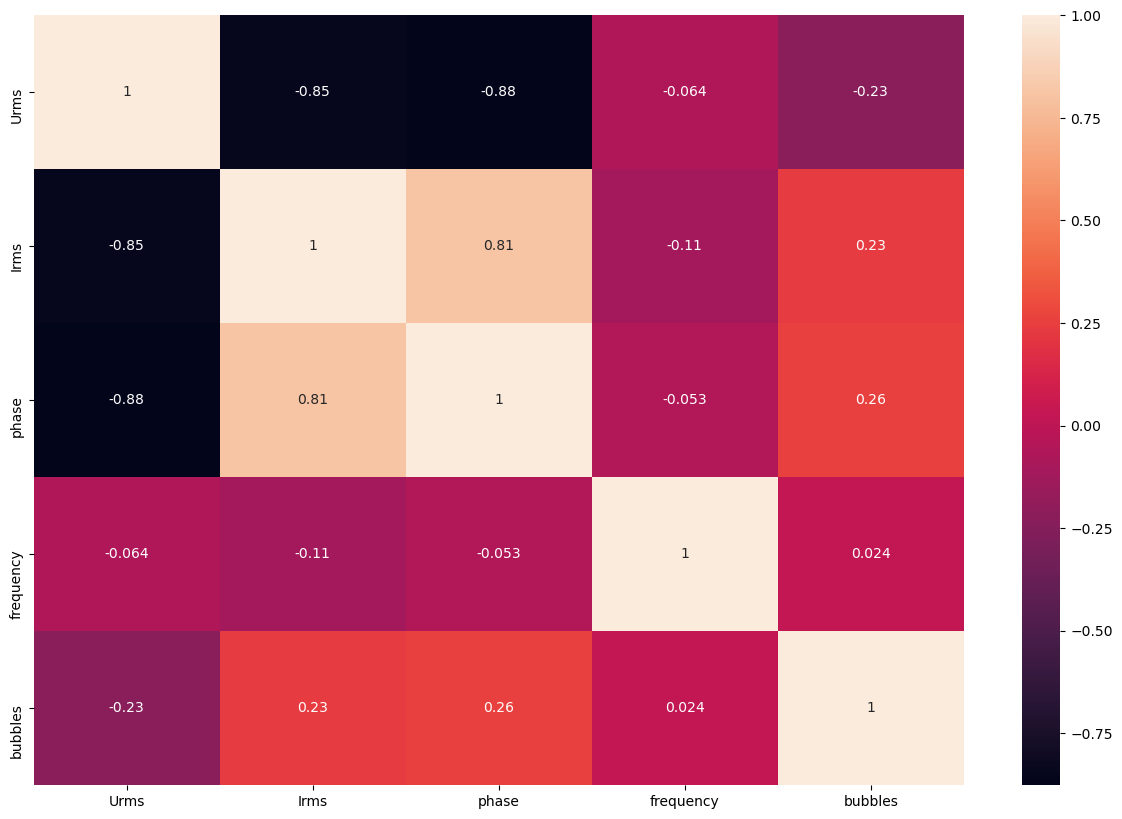

In [84]:
corr = df[features_PCA].corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels = corr.columns.values,
           yticklabels=corr.columns.values, annot = True)
plt.show()

### Decision Tree Classifier

In [85]:
features_dt = ['Urms', 'Irms', 'phase', 'frequency']
x1_dt = df[features_dt].copy()
x1_dt

,Urms,Irms,phase,frequency
0,25022.0,10618.0,10001.0,2077
1,25026.0,10625.0,10006.0,2077
2,25029.0,10634.0,10007.0,2077
3,25031.0,10641.0,10010.0,2077
4,25033.0,10648.0,10008.0,2077
...,...,...,...,...
589,24733.0,4495.0,9554.0,2207
590,24739.0,4496.0,9559.0,2207
591,24742.0,4495.0,9563.0,2207
592,24744.0,4496.0,9563.0,2207


In [86]:
categories_str = ['unbubbled', 'bubbled']
categories = {0 : 'unbubbled', 1 : 'bubbled'}
y_1_cat = y_1.replace(categories)
y_1_cat

0        bubbled
1        bubbled
2        bubbled
3        bubbled
4        bubbled
         ...    
589    unbubbled
590    unbubbled
591    unbubbled
592    unbubbled
593    unbubbled
Name: bubbles, Length: 594, dtype: object

In [87]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x1_dt, y_1_cat):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1
    
# Note that: 
# cross_val_score() parameter 'cv' will by default use StratifiedKFold spliting strategy if we just specify value of number of folds. 
# So you can bypass above step and just specify cv= 5 in cross_val_score() function

Fold:1, Train set: 534, Test set:60
Fold:2, Train set: 534, Test set:60
Fold:3, Train set: 534, Test set:60
Fold:4, Train set: 534, Test set:60
Fold:5, Train set: 535, Test set:59
Fold:6, Train set: 535, Test set:59
Fold:7, Train set: 535, Test set:59
Fold:8, Train set: 535, Test set:59
Fold:9, Train set: 535, Test set:59
Fold:10, Train set: 535, Test set:59


In [88]:
score = cross_val_score(tree.DecisionTreeClassifier(random_state= 42), x1_dt, y_1_cat, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [1.         0.98333333 1.         0.96666667 0.96610169 0.98305085
 1.         1.         0.98305085 0.98305085]
Average score: 0.99


The crossvalidation shows that the dataset is very homogeneous, without notable outliers. If there were notable outlieres the different splits of train and test data would result in vastly differing accuracy scores, depending on whether the outlier would be included in the training or test data. Now we will test for the optimal Tree depth:

In [89]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeClassifier(max_depth= val, random_state= 42), x1_dt, y_1_cat, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.695
Average score(2): 0.746
Average score(3): 0.796
Average score(4): 0.869
Average score(5): 0.904
Average score(6): 0.906
Average score(7): 0.951
Average score(8): 0.970
Average score(9): 0.987
Average score(10): 0.987


A tree depth of 6 is a good balance between depth and accuracy of prediction.

In [90]:
x_train,x_test,y_train,y_test = train_test_split(x1_dt,y_1_cat,test_size=0.33, random_state=42)

classifier_concentration = DecisionTreeClassifier(max_leaf_nodes=9,random_state=0)
classifier_concentration.fit(x_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=9, random_state=0)

In [91]:
y_predicted = classifier_concentration.predict(x_test)
np.unique(y_predicted)

array(['bubbled', 'unbubbled'], dtype=object)

# Model performance on training set
y_pred_train =classifier_concentration.predict(x_train)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print("Accuracy: {:.2f}".format(accuracy))
cm=confusion_matrix(y_train,y_pred_train)
print('Confusion Matrix: \n', cm)
print(classification_report(y_train, y_pred_train, target_names=categories_str))

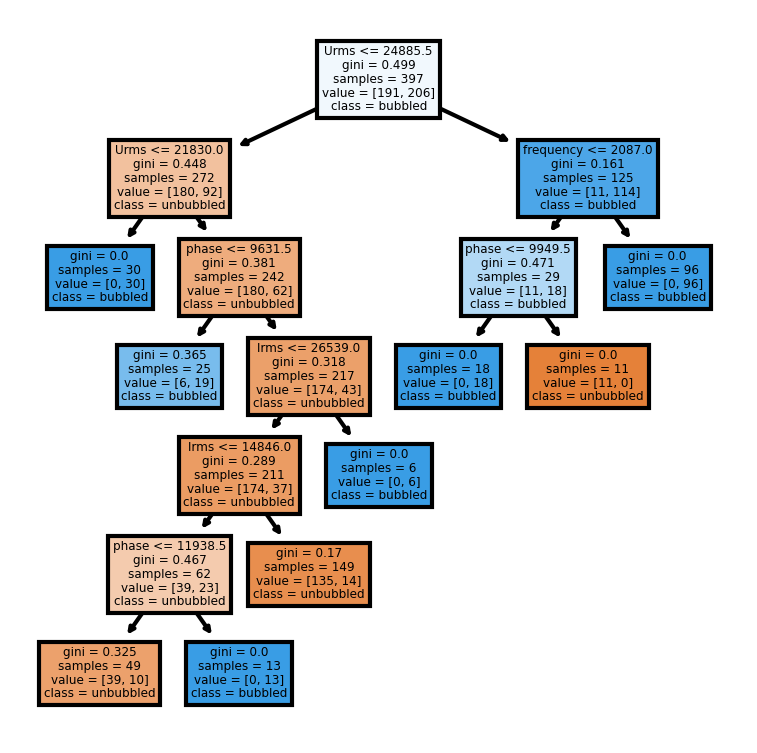

In [96]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
tree.plot_tree(classifier_concentration,
               feature_names = features_dt, 
               class_names=categories_str,
               filled = True);
plt.show(fig)

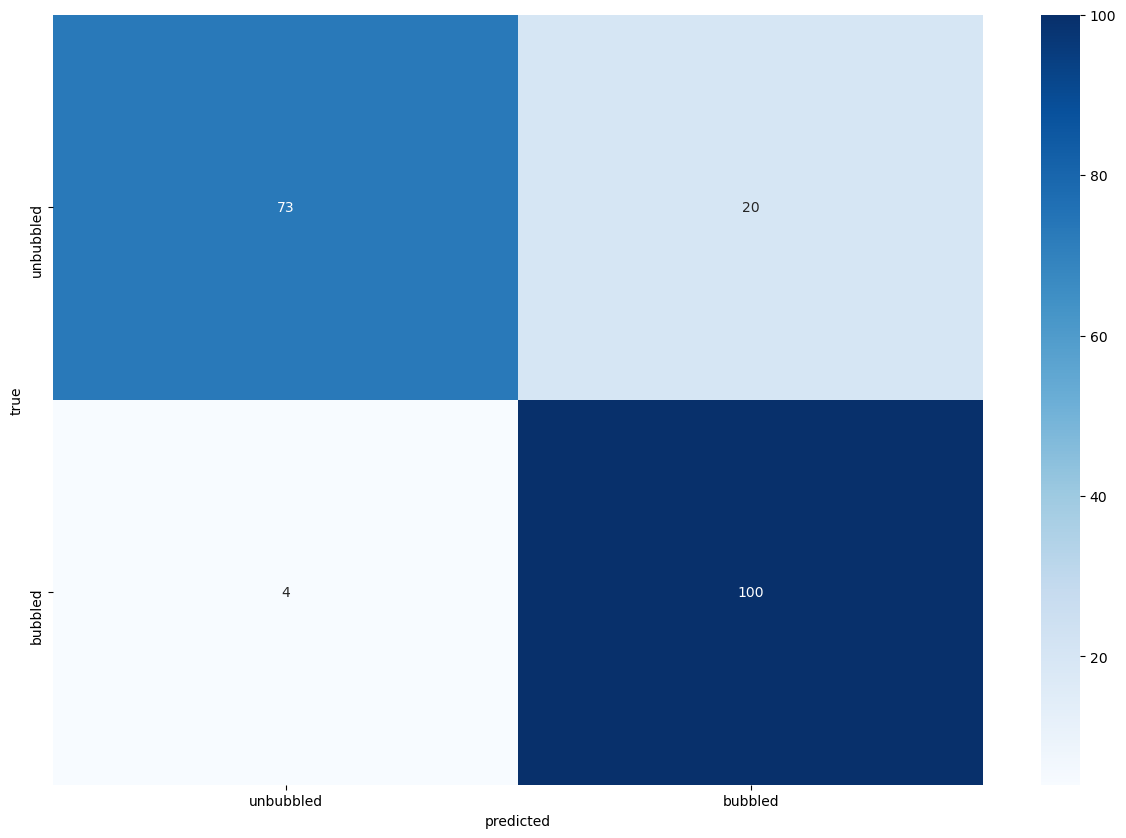

In [97]:
cf_matrix = confusion_matrix(y_test, y_predicted, labels= categories_str )
plt.subplots(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True, xticklabels=categories_str, yticklabels=categories_str, fmt='', cmap='Blues')
plt.xlabel("predicted") 
plt.ylabel("true")
plt.show()

### SVM

#### Classification

In [98]:
from sklearn import svm, datasets
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [99]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x1_dt, y_1_cat, test_size=0.20)


In [100]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred_lin = svclassifier.predict(X_test)
print("SVM - linear:")
print(accuracy_score(y_test,y_pred_lin))

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred_rbf = svclassifier.predict(X_test)
print("SVM - rbf:")
print(accuracy_score(y_test,y_pred_rbf))

SVM - linear:
0.680672268907563
SVM - rbf:
0.7983193277310925


### Regression

#### OLS

In [101]:
from sklearn import linear_model
# fit a regression model to the data: ols .. ordinary least square model

model = smf.ols(formula = "bubbles ~ Urms + Irms + phase", data = df).fit()

In [102]:
#info about model
model.summary()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.065   
Dependent Variable: bubbles          AIC:                827.2691
Date:               2021-08-13 14:45 BIC:                844.8166
No. Observations:   594              Log-Likelihood:     -409.63 
Df Model:           3                F-statistic:        14.74   
Df Residuals:       590              Prob (F-statistic): 2.86e-09
R-squared:          0.070            Scale:              0.23413 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
Intercept      -1.0300    1.1259  -0.9149  0.3606  -3.2412  1.1812
Urms            0.0000    0.0000   0.7213  0.4710  -0.0000  0.0001
Irms            0.0000    0.0000   1.3272  0.1850  -0.0000  0.0000
phase           0.0001    0.0000   2.7734  0.0057   0.0000  0.0001
-----------------------------------------------------------------
Omnibus:             3080.101      Durbin-Watson:         0.019  
Prob(Omnibus):       0.000         Jarque-Bera (JB):      72.310 
Skew:                0.021         Prob(JB):              0.000  
Kurtosis:            1.291         Condition No.:         1759799
=================================================================
* The condition number is large (2e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

#### SVM

In [103]:
features_SVM = ['Urms', 'Irms', 'phase', 'frequency']
target_SVM = ['bubbles']
X = df[features_SVM].copy()
X

,Urms,Irms,phase,frequency
0,25022.0,10618.0,10001.0,2077
1,25026.0,10625.0,10006.0,2077
2,25029.0,10634.0,10007.0,2077
3,25031.0,10641.0,10010.0,2077
4,25033.0,10648.0,10008.0,2077
...,...,...,...,...
589,24733.0,4495.0,9554.0,2207
590,24739.0,4496.0,9559.0,2207
591,24742.0,4495.0,9563.0,2207
592,24744.0,4496.0,9563.0,2207


In [104]:
y = df[target_SVM].copy()
y

,bubbles
0,1
1,1
2,1
3,1
4,1
...,...
589,0
590,0
591,0
592,0


In [105]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.40, random_state=42)

In [106]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
regressor = SVR(kernel='poly')
regressor.fit(X_train,y_train)

SVR(kernel='poly')

In [107]:
y_pred = regressor.predict(X_test)
y_pred

array([ 1.09403477, -0.88868845, -0.15107876,  0.107887  , -0.57463232,
        1.06072732, -0.69826621, -0.63778907, -1.05650387,  1.47269212,
       -0.12429034, -0.05943604, -0.57569545, -0.92540209,  0.04100277,
       -0.69013873, -1.12785848, -0.62614135, -0.66151128, -0.64308722,
       -0.58351196, -0.4932779 , -0.92667238,  1.09615565, -0.77212853,
       -0.68039933, -0.58625249, -0.67097093, -0.57695132, -0.94081558,
       -0.30045592, -1.38141004,  0.33440957, -0.62681352, -0.89581178,
        1.01982365,  0.36685158, -0.58381047, -0.52448545, -0.01201575,
       -0.23090367, -0.71738126, -0.919833  , -0.94929742, -0.29574331,
       -0.57172438, -0.14687525, -0.04830899, -0.97361643, -0.94248961,
       -0.1182825 ,  0.83056749, -0.49725639, -0.30240554, -0.54105585,
       -0.0179336 , -0.28661569, -0.66242604, -0.78488573, -0.66223302,
        0.85040704,  1.24982612, -0.92174831,  1.06790371, -0.68067409,
       -0.93182543, -1.04901024, -0.75687202, -0.69146934, -0.06

In [108]:
from sklearn.metrics import r2_score,mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

1.0043521916393248

#### PLSR